In [81]:
import pandas as pd

donations = pd.read_csv('donations.csv')
essays = pd.read_csv('essays.csv')
outcomes = pd.read_csv('outcomes.csv')
projects = pd.read_csv('projects.csv')
resources = pd.read_csv('resources.csv')

## if running from colab
# from google.colab import drive
# drive.mount('/content/drive')
# donations = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/donations.csv')
# essays = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/essays.csv')
# outcomes = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/outcomes.csv')
# projects = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/projects.csv')
# resources = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/resources.csv')


In [60]:
# merge projects
df = projects.merge(outcomes[['projectid', 'fully_funded']], on='projectid', how='left')

# merge essays
df = df.merge(essays[['projectid', 'title', 'short_description', 'need_statement', 'essay']], on='projectid', how='left')

# Aggregate resources
resources_summary = resources.groupby('projectid').agg({
    'item_unit_price': ['sum', 'mean', 'max'],
    'item_quantity': ['sum', 'mean'],
    'project_resource_type': pd.Series.nunique
})
resources_summary.columns = [
    'resource_cost_sum', 'resource_price_avg', 'resource_price_max',
    'item_quantity_sum', 'item_quantity_avg', 'resource_type_count'
]
resources_summary = resources_summary.reset_index()
df = df.merge(resources_summary, on='projectid', how='left')

In [ ]:
# merge donations
df = df.merge(donations, on='projectid', how='left')


# Drop columns with too many missing values
missing_pct = df.isnull().mean().sort_values(ascending=False)
cols_to_drop = missing_pct[missing_pct > 0.4].index
df = df.drop(columns=cols_to_drop)

# Drop rows with missing labels
df = df.dropna(subset=['fully_funded'])


# Fill other NaNs with median
df = df.fillna({
    'students_reached': df['students_reached'].median(),
    'total_price_including_optional_support': df['total_price_including_optional_support'].median()
})

# text features 
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')
df['essay_length'] = df['essay'].astype(str).apply(len)
df['title_length'] = df['title'].astype(str).apply(len)
df['need_statement_length'] = df['need_statement'].astype(str).apply(len)
df['short_description_length'] = df['short_description'].astype(str).apply(len)

df['month_posted'] = df['date_posted'].dt.month
df['year_posted'] = df['date_posted'].dt.year
df['fully_funded_bin'] = df['fully_funded'].map({'t': 1, 'f': 0})

# add Donation_count
donation_counts = donations.groupby('projectid').size().rename('total_number_of_donations')
df['donation_counts'] = df['projectid'].map(donation_counts)

# Filter for NY, CA, FL
df = df[df['school_state'].isin(['NM','MI','UT','AZ','HI','CT','AA','WA','GA','OK','AE','CO','SC','TX'])]
df.to_csv('df.csv', index=False)
df.shape, df.columns.tolist()

((1205161, 72),
 ['projectid',
  'teacher_acctid',
  'schoolid',
  'school_ncesid',
  'school_latitude',
  'school_longitude',
  'school_city',
  'school_state',
  'school_zip',
  'school_metro',
  'school_district',
  'school_county',
  'school_charter',
  'school_magnet',
  'school_year_round',
  'school_nlns',
  'school_kipp',
  'school_charter_ready_promise',
  'teacher_prefix',
  'teacher_teach_for_america',
  'teacher_ny_teaching_fellow',
  'primary_focus_subject',
  'primary_focus_area',
  'secondary_focus_subject',
  'secondary_focus_area',
  'resource_type',
  'poverty_level',
  'grade_level',
  'fulfillment_labor_materials',
  'total_price_excluding_optional_support',
  'total_price_including_optional_support',
  'students_reached',
  'eligible_double_your_impact_match',
  'eligible_almost_home_match',
  'date_posted',
  'fully_funded',
  'title',
  'short_description',
  'need_statement',
  'essay',
  'resource_cost_sum',
  'resource_price_avg',
  'resource_price_max',
  'it

In [62]:
print("Number of projects:", df.shape[0])
print("Columns:", df.shape[1])
print(df['fully_funded'].value_counts(normalize=True))


Number of projects: 1205161
Columns: 72
fully_funded
t    0.896665
f    0.103335
Name: proportion, dtype: float64


In [63]:
print("Poverty level")
print(df['poverty_level'].value_counts())

print("\nGrade level")
print(df['grade_level'].value_counts())

print("\nSubject")
print(df['primary_focus_area'].value_counts())

print("\nStates")
print(df['school_state'].value_counts().head(10))


Poverty level
poverty_level
highest poverty     697042
high poverty        313030
moderate poverty    151559
low poverty          43530
Name: count, dtype: int64

Grade level
grade_level
Grades PreK-2    442556
Grades 3-5       357113
Grades 6-8       205805
Grades 9-12      199640
Name: count, dtype: int64

Subject
primary_focus_area
Literacy & Language    524488
Math & Science         295568
Music & The Arts       127488
Special Needs           81559
Applied Learning        78764
History & Civics        59051
Health & Sports         38086
Name: count, dtype: int64

States
school_state
CA    722962
NY    294695
FL    187504
Name: count, dtype: int64


**EDA**

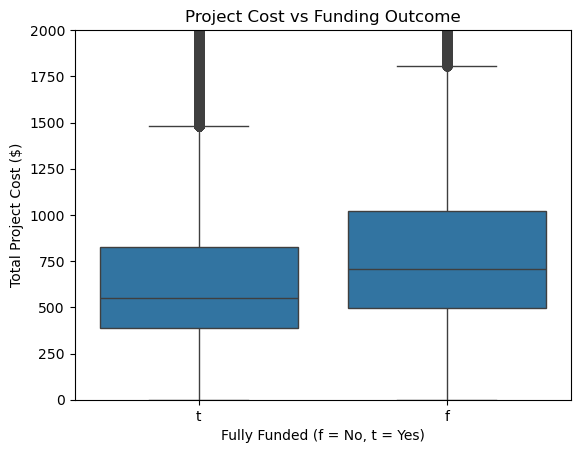

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='fully_funded', y='total_price_including_optional_support', data=df)
plt.title('Project Cost vs Funding Outcome')
plt.xlabel('Fully Funded (f = No, t = Yes)')
plt.ylabel('Total Project Cost ($)')
plt.ylim(0, 2000)
plt.show()

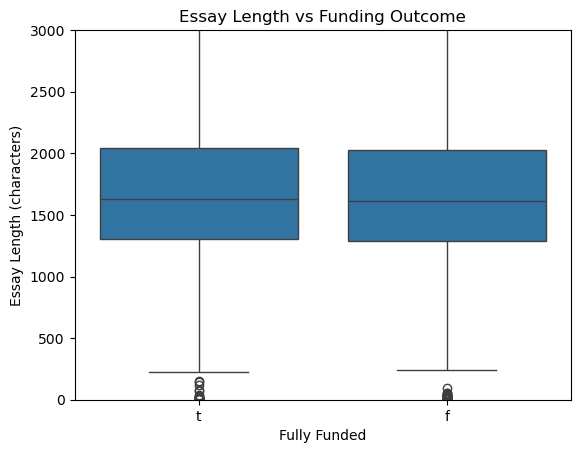

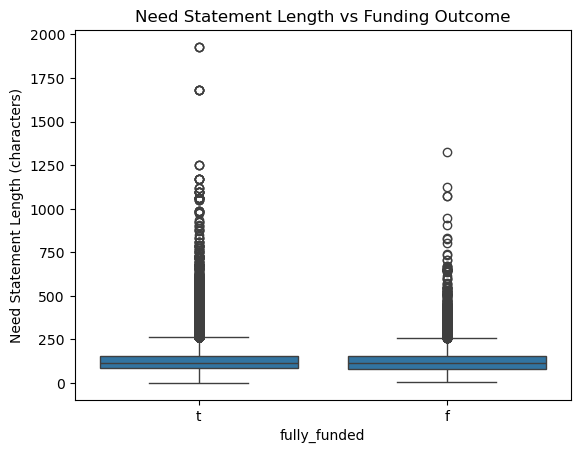

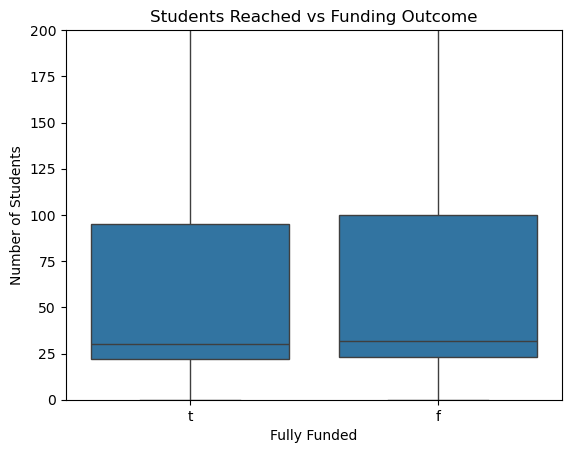

In [65]:
sns.boxplot(x='fully_funded', y='essay_length', data=df)
plt.title('Essay Length vs Funding Outcome')
plt.xlabel('Fully Funded')
plt.ylabel('Essay Length (characters)')
plt.ylim(0, 3000)
plt.show()

sns.boxplot(x='fully_funded', y='need_statement_length', data=df)
plt.title('Need Statement Length vs Funding Outcome')
plt.ylabel('Need Statement Length (characters)')
plt.show()


sns.boxplot(x='fully_funded', y='students_reached', data=df)
plt.title('Students Reached vs Funding Outcome')
plt.xlabel('Fully Funded')
plt.ylabel('Number of Students')
plt.ylim(0, 200)
plt.show()


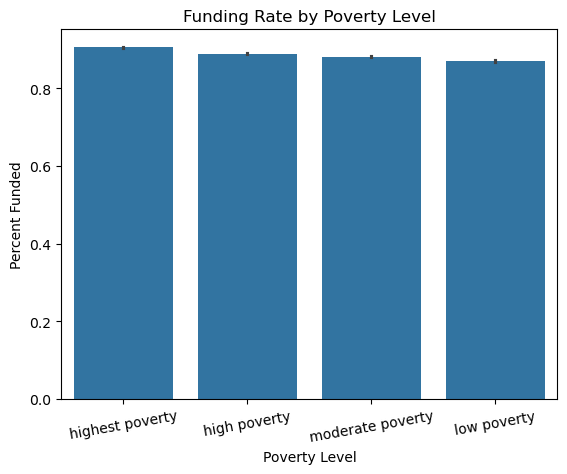

In [66]:

sns.barplot(x='poverty_level', y='fully_funded_bin', data=df)
plt.title('Funding Rate by Poverty Level')
plt.ylabel('Percent Funded')
plt.xlabel('Poverty Level')
plt.xticks(rotation=10)
plt.show()




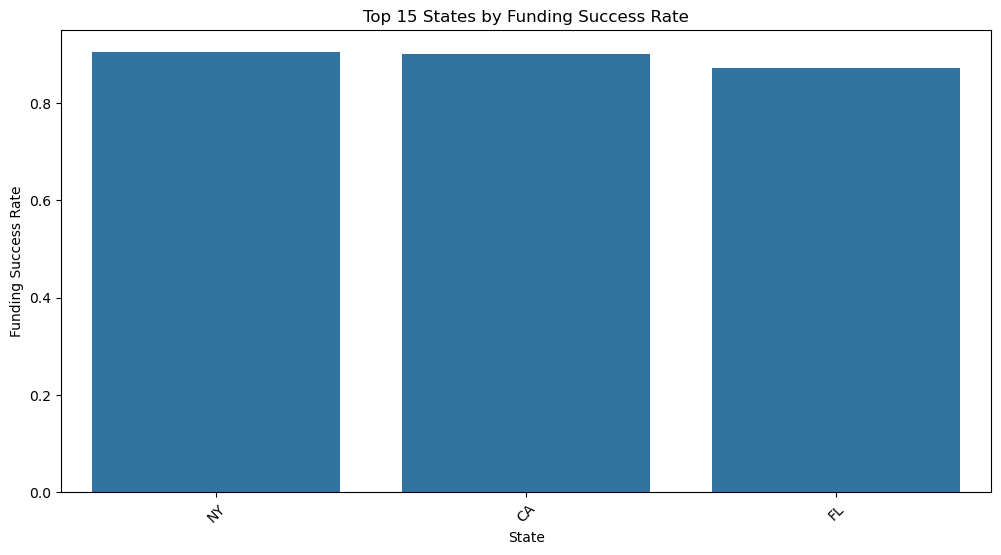

In [67]:
# Group by state
state_success = df.groupby('school_state')['fully_funded_bin'].mean().sort_values(ascending=False)

# Plot top 15 states by funding success
plt.figure(figsize=(12, 6))
sns.barplot(x=state_success.head(15).index, y=state_success.head(15).values)
plt.title('Top 15 States by Funding Success Rate')
plt.xlabel('State')
plt.ylabel('Funding Success Rate')
plt.xticks(rotation=45)
plt.show()

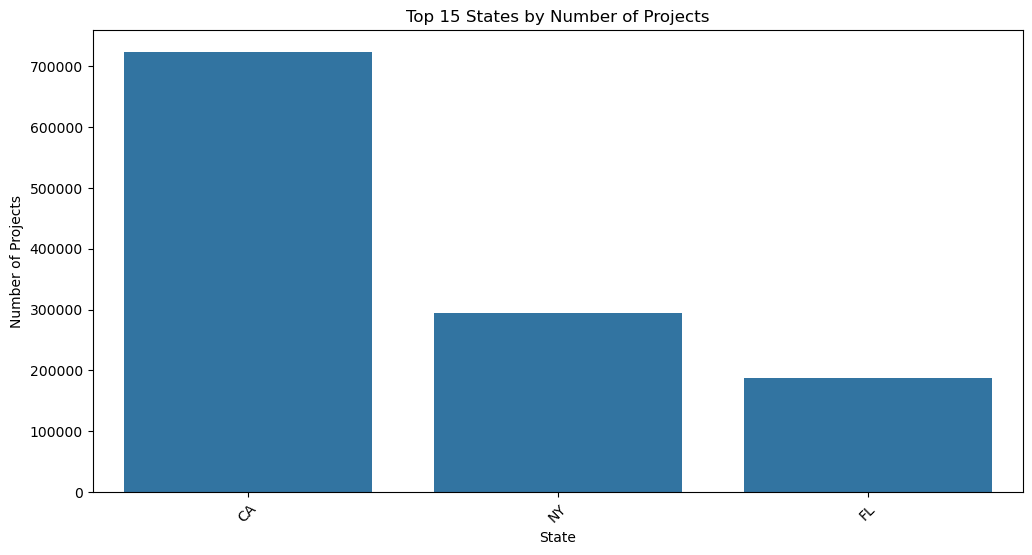

In [68]:
state_counts = df['school_state'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.head(15).index, y=state_counts.head(15).values)
plt.title('Top 15 States by Number of Projects')
plt.xlabel('State')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.show()


**Features**

In [ ]:

# features
all_feature_cols = [
    # These are the ones I had before
    'total_price_including_optional_support',
    'resource_cost_sum',
    'essay_length',
    'title_length',
    'need_statement_length',
    'poverty_level',
    'school_state',
    'students_reached',

    # These are the features we had for our merged_dataset. I dropped some columns such as 'projectid', 'teacher_acctid', 'schoolid', 'donor_acctid' since they don't 
    # help with our models. There are also a few columns that are in the merged_dataset but i didn't find them: 
    # ['at_least_1_teacher_referred_donor', 'at_least_1_green_donation', 'great_chat', 'three_or_more_non_teacher_referred_donors', 
    # 'one_non_teacher_referred_donor_giving_100_plus', 'donation_from_thoughtful_donor', 'great_messages_proportion', 'teacher_referred_count', 
    # 'non_teacher_referred_count']
    'resource_type',
    'item_quantity_sum',
    'donation_total',         
    'donor_state',
    'donation_counts',
]

# Drop rows with missing required values
df_model = df[all_feature_cols + ['fully_funded_bin']].dropna()

# Define X and y
X = df_model[all_feature_cols]
y = df_model['fully_funded_bin']

df_model.to_csv('feature_matrix.csv', index=False)
df_model


,total_price_including_optional_support,resource_cost_sum,essay_length,title_length,need_statement_length,poverty_level,school_state,students_reached,resource_type,item_quantity_sum,donation_total,donor_state,donation_counts,fully_funded_bin
44787,952.14,377.99,2437,20,111,highest poverty,FL,17.0,Technology,2.0,25.00,FL,3.0,1
44788,952.14,377.99,2437,20,111,highest poverty,FL,17.0,Technology,2.0,810.00,FL,3.0,1
44789,952.14,377.99,2437,20,111,highest poverty,FL,17.0,Technology,2.0,117.14,FL,3.0,1
44790,370.60,258.48,2318,16,140,highest poverty,FL,20.0,Technology,4.0,100.00,CA,6.0,1
44792,370.60,258.48,2318,16,140,highest poverty,FL,20.0,Technology,4.0,40.19,NY,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237040,281.71,0.00,1345,23,75,highest poverty,NY,0.0,Supplies,0.0,254.00,NY,1.0,1
3237041,1376.83,0.00,2271,66,263,highest poverty,NY,0.0,Technology,0.0,1241.00,MA,1.0,1
3237042,152.44,0.00,1239,62,75,moderate poverty,NY,0.0,Supplies,0.0,125.00,NJ,1.0,1
3237043,152.44,0.00,2272,150,75,highest poverty,NY,0.0,Books,0.0,137.00,NY,1.0,1


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder


In [71]:
# One hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['resource_type', 'donor_state', 'poverty_level', 'school_state'], drop_first=True)


from sklearn.preprocessing import StandardScaler
# Scale numeric features
numeric_cols = [
    'total_price_including_optional_support',
    'resource_cost_sum',
    'essay_length',
    'title_length',
    'need_statement_length',
    'students_reached',
]
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

In [72]:
# split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)


In [73]:
print("Feature matrix shape:", X_encoded.shape)
print("distribution:\n", y.value_counts(normalize=True))

Feature matrix shape: (951312, 78)
distribution:
 fully_funded_bin
1    0.919665
0    0.080335
Name: proportion, dtype: float64


In [74]:
# ==================== MODELS ====================
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42).fit(X_train, y_train)
sgd = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

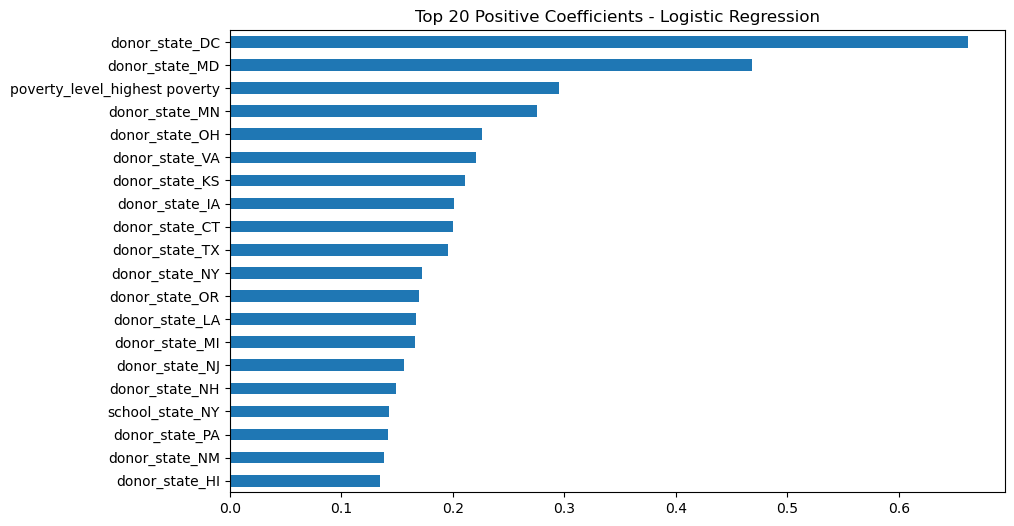

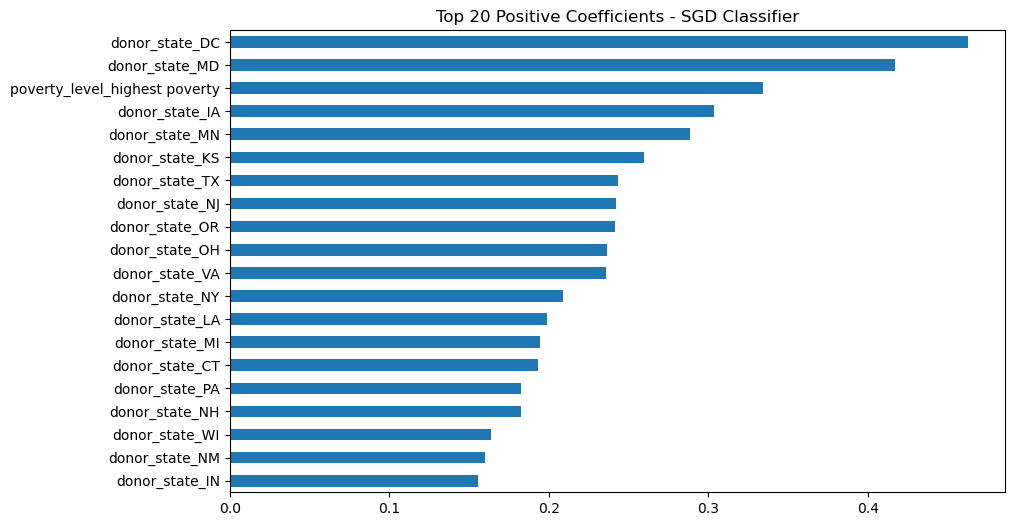

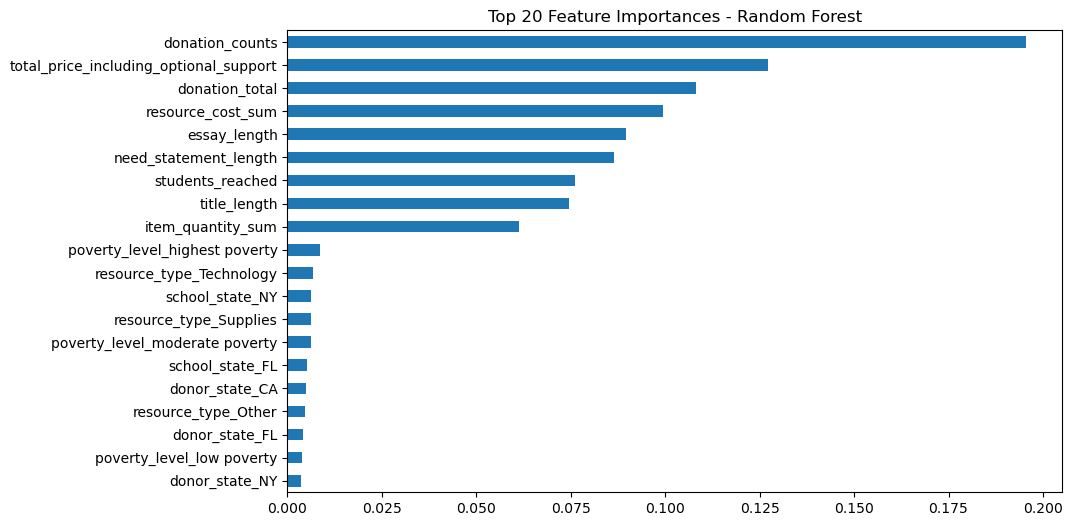

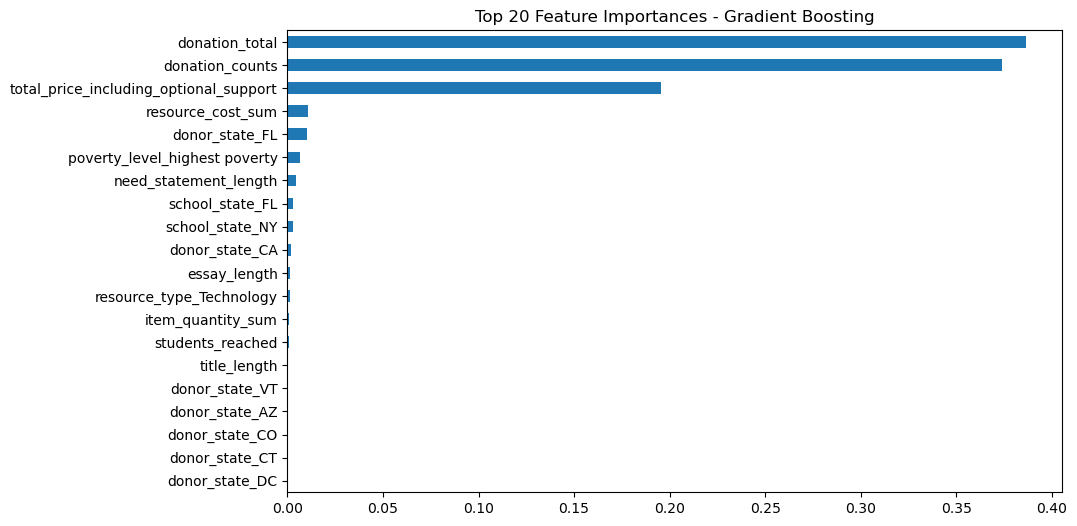

In [75]:
# ==================== FEATURE IMPORTANCE ====================
# Logistic Regression
lr_importance = pd.DataFrame(lr.coef_[0], index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
lr_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Positive Coefficients - Logistic Regression")
plt.show()

# SGD
sgd_importance = pd.DataFrame(sgd.coef_[0], index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
sgd_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Positive Coefficients - SGD Classifier")
plt.show()

# Random Forest
rf_importance = pd.DataFrame(rf.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
rf_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()

# Gradient Boosting
gb_importance = pd.DataFrame(gb.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
gb_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - Gradient Boosting")
plt.show()

## Feature Importance Highlights

### 1. Logistic Regression
- **Most positively associated with success:**
  - `school_state_HI`, `school_state_NH`, `school_state_DC`
  - `poverty_level_highest poverty`
- Strong presence of **school_state** dummy variables shows that **geographic location** has high predictive power in linear separation.
- Also, `need_statement_length` appears to be relevant.

---

### 2. SGD Classifier
- Similar to Logistic Regression, but with **`resource_cost_sum`** as the top coefficient.
- High variance in coefficients (e.g., 1.2 for resource cost), possibly due to **regularization differences**.
- **State features** and `need_statement_length` are again **prominent**.

---

### 3. Random Forest
- **Top features:**
  - `total_price_including_optional_support`
  - `resource_cost_sum`
  - `essay_length`, `need_statement_length`, `students_reached`
- Tree-based models focus more on **numeric and continuous features**.
- **School states** and **poverty level dummies** rank lower — likely due to less consistent impact across decision splits.

---

### 4. Gradient Boosting
- **Dominated by**: `total_price_including_optional_support` (massively high importance)
- Next most important:
  - `need_statement_length`
  - `poverty_level_highest poverty`
  - A few `school_state` variables
- Suggests that **cost** and **poverty severity** are especially powerful when boosting decision trees.


 ## So I think include Poverty Level, essay/need statement length, cost features. Don't include state, or focus on specific state.



In [76]:
# Get predicted probability of being funded (1 = funded)
full_probs = gb.predict_proba(X_encoded)[:, 1]

# Attach predictions to your original model dataframe
df_model['predicted_prob'] = full_probs
df_model['projectid'] = df.loc[df_model.index, 'projectid']  # attach project ID back

# Sort by lowest predicted probability (least likely to be funded)
df_ranked = df_model.sort_values(by='predicted_prob', ascending=True)

# Select bottom 10%
cutoff = int(len(df_ranked) * 0.10)
bottom_10 = df_ranked.head(cutoff)

# Optional: save or display
bottom_10[['projectid', 'predicted_prob']].to_csv('projects_for_expert_review.csv', index=False)
print(bottom_10[['projectid', 'predicted_prob']].head(10))


                                projectid  predicted_prob
1019036  6dd96be448d94cc1ae0573b0c32f062c        0.000523
861207   7f790887fb3815d7fed75cfd917b52b1        0.000697
2707103  b56e230cef026c053d91085736cecc9c        0.000697
1706736  b481c42a3441d35a545f4813fadf8a8b        0.000755
2506747  a598382fd34aa53330559b442d5242d9        0.000828
2768277  42f8170ac9c3ee8fc07862d9098154ff        0.001065
1574666  da6d225686059ced0ddc19d03dfe6cf6        0.001176
1379716  aace259cfbecdf27019a14048b94585a        0.001250
3087311  4fc66c784de1369dd27bfb70a6734570        0.001293
3166320  0599f5b09b3d07d65c79ad06d4741dd9        0.001313


In [77]:
# ==================== EVALUATION ====================
y_probs = {
    'Logistic Regression': lr.predict_proba(X_test)[:, 1],
    'Random Forest': rf.predict_proba(X_test)[:, 1],
    'Gradient Boosting': gb.predict_proba(X_test)[:, 1],
    'SGD Classifier': sgd.predict_proba(X_test)[:, 1],
    'KNN': knn.predict_proba(X_test)[:, 1],
}

results = pd.DataFrame({
    'Model': list(y_probs.keys()),
    'ROC AUC': [roc_auc_score(y_test, prob) for prob in y_probs.values()]
})
print(results)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

for model_name, y_prob in y_probs.items():
    y_pred = (y_prob >= 0.5).astype(int)
    print(f"\n{model_name} Classification Report (focus on not-funded projects):")
    print(classification_report(y_test, y_pred, target_names=['Not Funded', 'Funded']))

    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)

    print(f"Precision (Not Funded): {precision:.3f}")
    print(f"Recall (Not Funded): {recall:.3f}")
    print(f"F1 Score (Not Funded): {f1:.3f}")





python(60535) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


                 Model   ROC AUC
0  Logistic Regression  0.835832
1        Random Forest  0.996155
2    Gradient Boosting  0.913433
3       SGD Classifier  0.820110
4                  KNN  0.902533

Logistic Regression Classification Report (focus on not-funded projects):
              precision    recall  f1-score   support

  Not Funded       0.57      0.07      0.12     15285
      Funded       0.92      1.00      0.96    174978

    accuracy                           0.92    190263
   macro avg       0.75      0.53      0.54    190263
weighted avg       0.90      0.92      0.89    190263

Precision (Not Funded): 0.567
Recall (Not Funded): 0.066
F1 Score (Not Funded): 0.118

Random Forest Classification Report (focus on not-funded projects):
              precision    recall  f1-score   support

  Not Funded       0.96      0.81      0.88     15285
      Funded       0.98      1.00      0.99    174978

    accuracy                           0.98    190263
   macro avg       0.97    

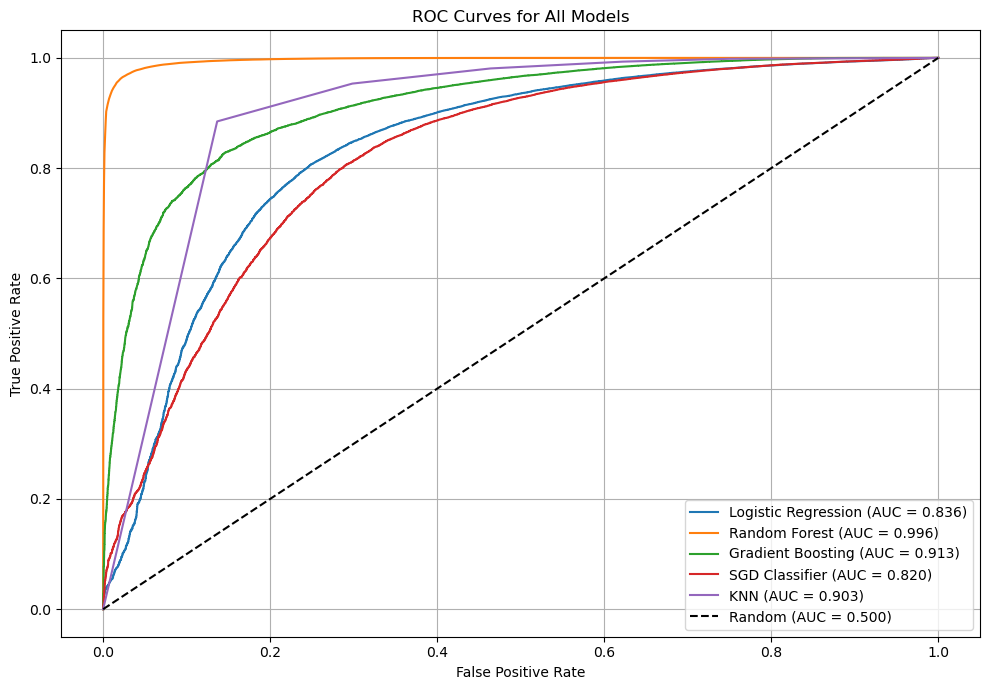

In [78]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 7))

for model_name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [79]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Get predicted labels (using default threshold = 0.5)
y_preds = {
    'Logistic Regression': lr.predict(X_test),
    'Random Forest': rf.predict(X_test),
    'Gradient Boosting': gb.predict(X_test),
    'SGD Classifier': sgd.predict(X_test),
    'KNN': knn.predict(X_test),
}

metrics = []

for model_name, y_pred in y_preds.items():
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc_score(y_test, y_probs[model_name])
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df.sort_values(by='F1-score', ascending=False))


                 Model  Precision    Recall  F1-score       AUC
1        Random Forest   0.984519  0.996920  0.990680  0.996155
4                  KNN   0.960324  0.980866  0.970486  0.902533
2    Gradient Boosting   0.943697  0.989130  0.965880  0.913433
3       SGD Classifier   0.925812  0.994828  0.959080  0.820110
0  Logistic Regression   0.924258  0.995594  0.958601  0.835832


---